## Load Data

In [2]:
import pandas as pd

In [3]:
from aifeel.util import gen_dataframe, read_corpus
from aifeel.util.preprocess import preprocess_text
from aifeel.util.feature_extraction import extract_features, feature_to_vector
from aifeel.model.nn import NNClassifier

from sklearn.feature_extraction.text import CountVectorizer


2024-03-02 18:47:06.227952: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
negative_corpus, positive_corpus = read_corpus("negative-reviews"), read_corpus(
    "positive-reviews"
)
negative_words, positive_words = read_corpus("negative-words"), read_corpus(
    "positive-words"
)

df = gen_dataframe(positive_corpus, negative_corpus, random_state=42)
df["clean_review"] = df["review"].apply(preprocess_text)

# # Convert lists to sets
positive_words = set(read_corpus("positive-words"))
negative_words = set(read_corpus("negative-words"))

cv = CountVectorizer(max_features=1000 - 8)  # 6 primary features + 2 extra features
cv.fit(df["clean_review"])


def vectorizer(review):
    result = cv.transform([review])
    return result.toarray()[0].tolist()  # type: ignore
    #        ^      ^          ^
    #   spmatrix ndarray    list
    # it definitely exists, type hinter is just bad


df["features"] = df["clean_review"].apply(
    extract_features, args=(positive_words, negative_words)
)
df.head()

,tag,review,clean_review,features
0,0,None,none,"{'negative_count': 0, 'positive_count': 0, 'co..."
1,1,"Color, internet, ringtones, camera w/flash, ch...",color internet ringtones camera w flash charge...,"{'negative_count': 1, 'positive_count': 2, 'co..."
2,0,"small screen, low battery life (can be upgrade...",small screen low battery life upgraded games m...,"{'negative_count': 0, 'positive_count': 2, 'co..."
3,1,Near photo perfect print quality,near photo perfect print quality,"{'negative_count': 0, 'positive_count': 1, 'co..."
4,0,Short battery life,short battery life,"{'negative_count': 0, 'positive_count': 0, 'co..."


## Data Exploration

In [5]:
df.shape

(40000, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tag           40000 non-null  object
 1   review        40000 non-null  object
 2   clean_review  40000 non-null  object
 3   features      40000 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [7]:
df[df['review'] == 'None'].count()

tag             299
review          299
clean_review    299
features        299
dtype: int64

In [8]:
# Convert 'tag' column to integer type
df['tag'] = df['tag'].astype(int)

print(df['tag'].dtype)


int64


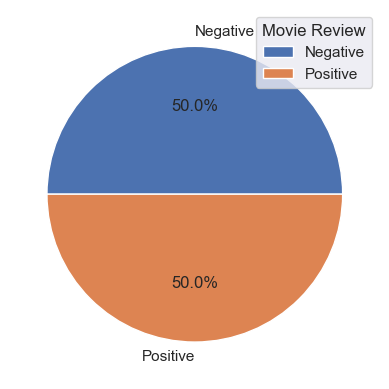

In [9]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()

label_counts = df['tag'].value_counts()

label_names = {0: 'Negative', 1: 'Positive'}
label_counts.index = label_counts.index.map(label_names)

plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.legend(title="Movie Review") 
plt.show()


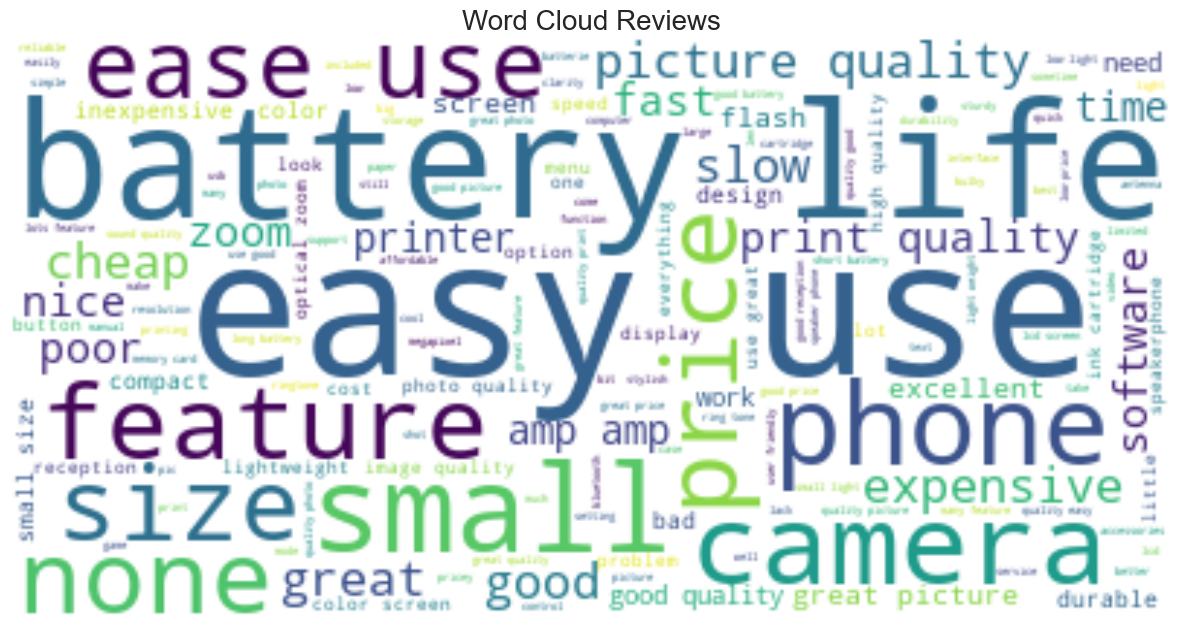

In [10]:
from wordcloud import WordCloud

text_data = ' '.join(df['clean_review'].dropna())

wordcloud = WordCloud(background_color='white').generate(text_data)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Reviews', fontsize=20)
plt.show()


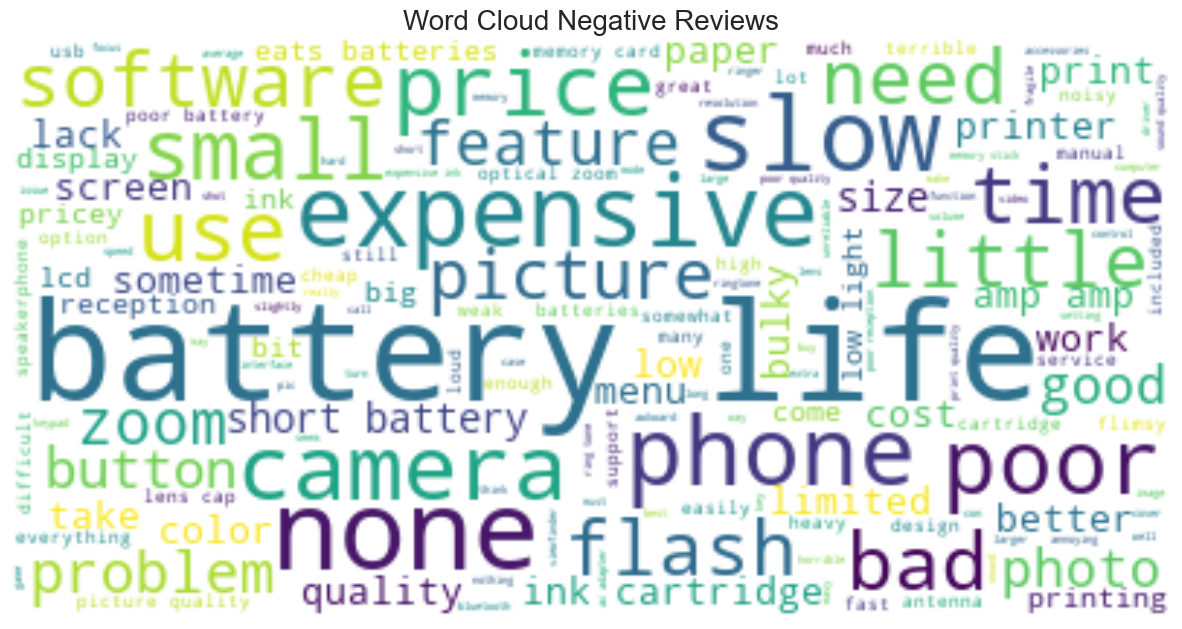

In [11]:

neg_data = " ".join(df[df["tag"] == 0]["clean_review"])
wordcloud = WordCloud(background_color='white').generate(neg_data)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Negative Reviews', fontsize=20)
plt.show()


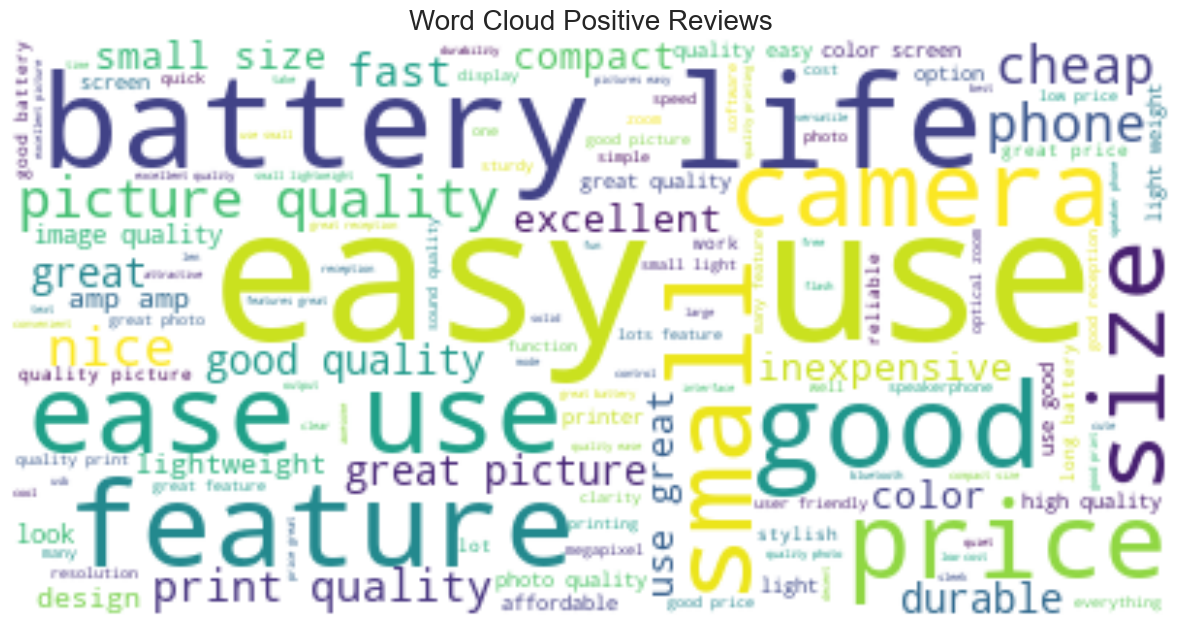

In [12]:
pos_data = ' '.join(df[df['tag']==1]['clean_review'].dropna())

wordcloud = WordCloud(background_color='white').generate(pos_data)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Positive Reviews', fontsize=20)
plt.show()


In [13]:
data = df.copy()
data.head()

,tag,review,clean_review,features
0,0,None,none,"{'negative_count': 0, 'positive_count': 0, 'co..."
1,1,"Color, internet, ringtones, camera w/flash, ch...",color internet ringtones camera w flash charge...,"{'negative_count': 1, 'positive_count': 2, 'co..."
2,0,"small screen, low battery life (can be upgrade...",small screen low battery life upgraded games m...,"{'negative_count': 0, 'positive_count': 2, 'co..."
3,1,Near photo perfect print quality,near photo perfect print quality,"{'negative_count': 0, 'positive_count': 1, 'co..."
4,0,Short battery life,short battery life,"{'negative_count': 0, 'positive_count': 0, 'co..."


In [14]:
data.drop(columns=['review', 'clean_review'], axis=1, inplace=True)
data.head()

,tag,features
0,0,"{'negative_count': 0, 'positive_count': 0, 'co..."
1,1,"{'negative_count': 1, 'positive_count': 2, 'co..."
2,0,"{'negative_count': 0, 'positive_count': 2, 'co..."
3,1,"{'negative_count': 0, 'positive_count': 1, 'co..."
4,0,"{'negative_count': 0, 'positive_count': 0, 'co..."


In [15]:
normalized_features = pd.json_normalize(data['features'])
data = pd.concat([data, normalized_features], axis=1)
data = data.drop('features', axis=1)

data.head()

,tag,negative_count,positive_count,contains_no,pronoun_count,contains_exclamation,log_length,count_pseudo_negative,count_pseudo_positive
0,0,0,0,0,0,0,1.609438,0,0
1,1,1,2,0,0,0,4.615121,0,0
2,0,0,2,0,0,0,4.174387,0,0
3,1,0,1,0,0,0,3.496508,0,0
4,0,0,0,0,0,0,2.944439,0,0


In [31]:
def plot_bar_chart_with_counts(data, column_name):
    plt.figure(figsize=(10, 6))

    value_counts = data[column_name].value_counts().sort_index()
    ax = value_counts.plot(kind='bar')

    for i, v in enumerate(value_counts):
        ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

    plt.title(f'Bar Chart of {column_name} Count')
    plt.xlabel(f'{column_name} Count')
    plt.ylabel('Frequency')
    plt.show()


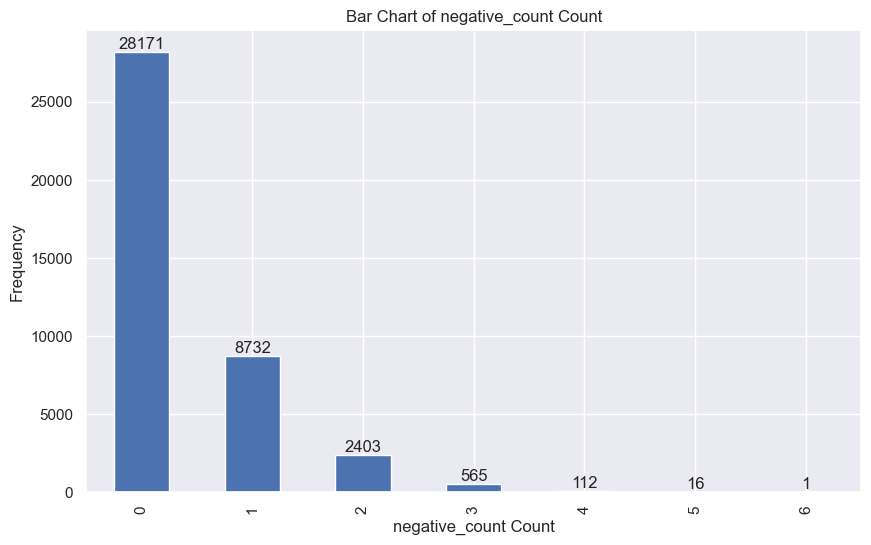

In [32]:
plot_bar_chart_with_counts(data, 'negative_count')

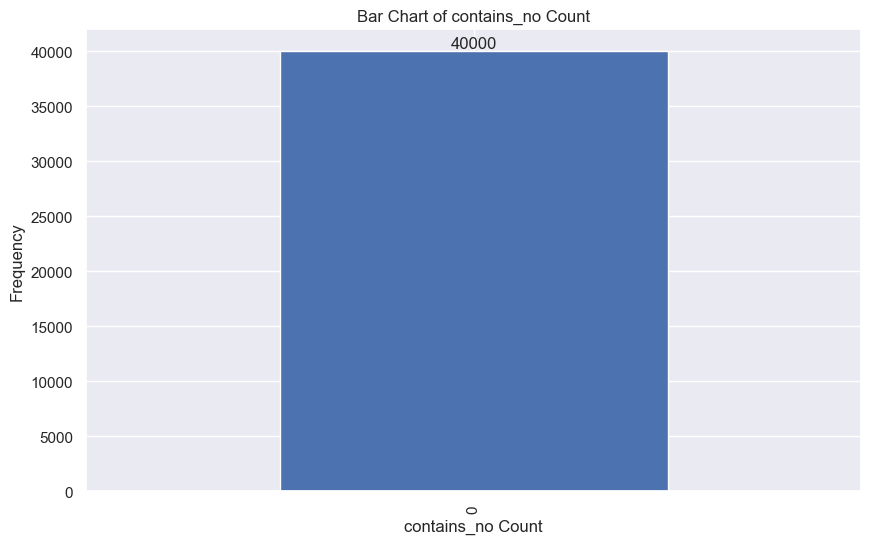

In [34]:
plot_bar_chart_with_counts(data, 'contains_no')

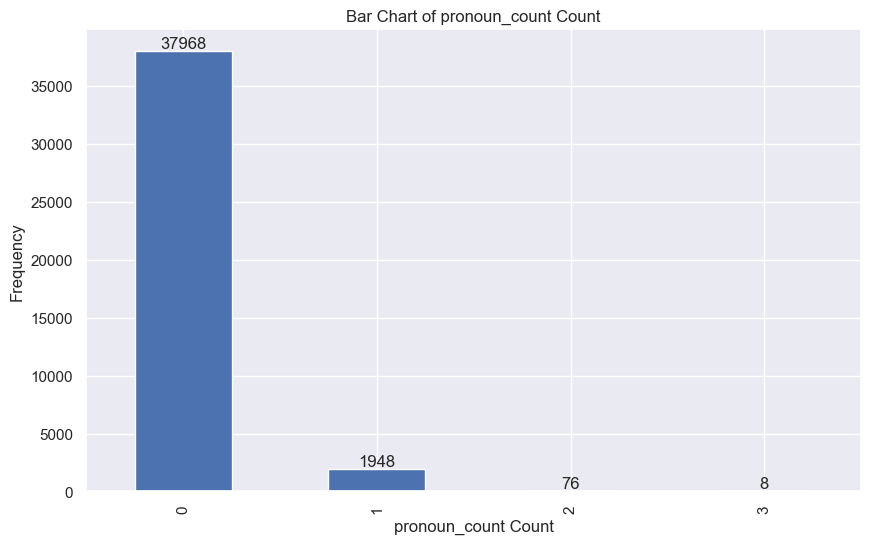

In [35]:
plot_bar_chart_with_counts(data, 'pronoun_count')

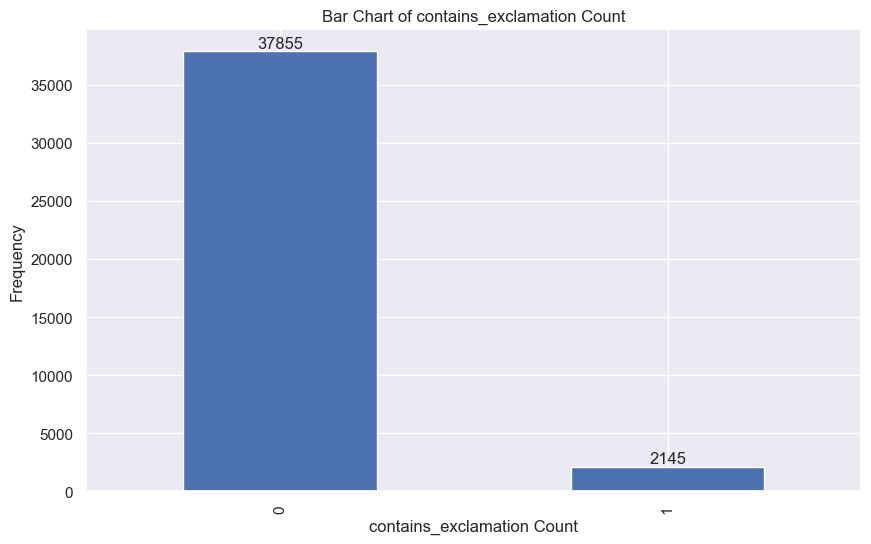

In [36]:
plot_bar_chart_with_counts(data, 'contains_exclamation')

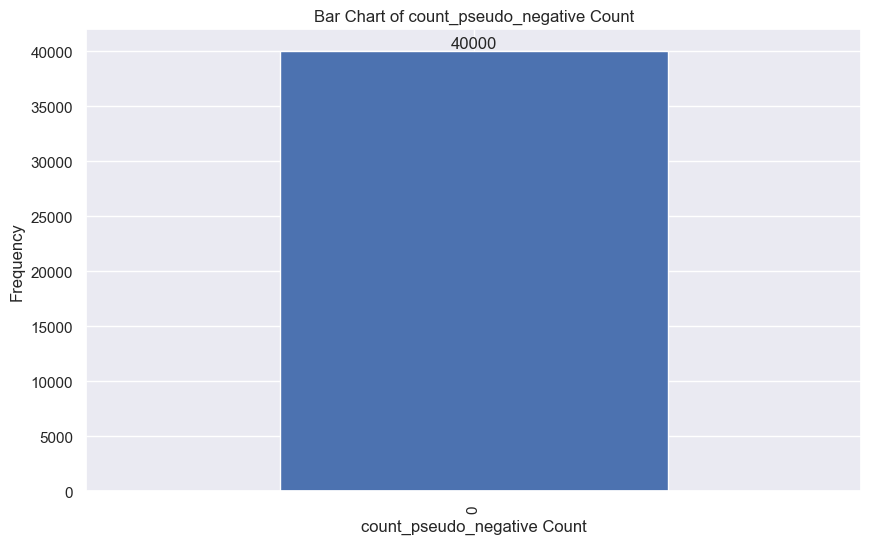

In [37]:
plot_bar_chart_with_counts(data, 'count_pseudo_negative')

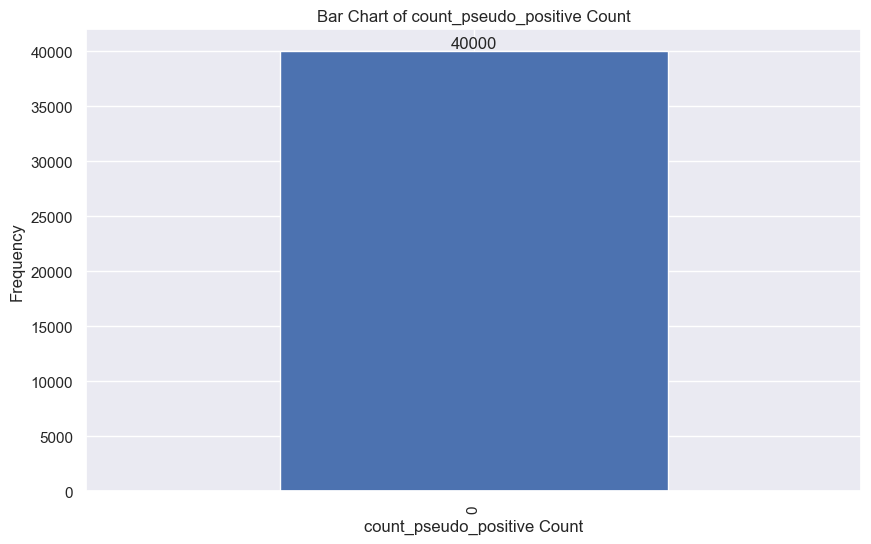

In [38]:
plot_bar_chart_with_counts(data, 'count_pseudo_positive')

## Split Dataset

In [17]:
X = data.drop(['tag'], axis = 1)
y = data['tag']

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

## Model

### SVM

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import (
confusion_matrix,classification_report, f1_score, 
recall_score, accuracy_score, precision_score,
ConfusionMatrixDisplay
)

#### Grid Search

Parameters are as follows:

- C: It is the regularization parameter, C, of the error term.
- kernel: It specifies the kernel type to be used in the algorithm. It can be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, or a callable. The default value is ‘rbf’.
- degree: It is the degree of the polynomial kernel function (‘poly’) and is ignored by all other kernels. The default valueis 3.
- gamma: It is the kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’. If gamma is ‘auto’, then 1/n_features will be used instead.

In [20]:
# from sklearn.model_selection import GridSearchCV
# grid = {

#     'C':[0.01, 0.1, 1, 10],

#     'kernel' : ["linear", "poly", "rbf", "sigmoid"],

#     'degree': [1, 3, 5],
     
#     'gamma' : ["scale"]

# }

# svm  = SVC ()

# svm_cv = GridSearchCV(svm, grid, cv = 5)

# svm_cv.fit(X_train,y_train)

# print("Best Parameters:",svm_cv.best_params_)

# print("Train Score:",svm_cv.best_score_)

# print("Test Score:",svm_cv.score(X_test,y_test))

- Best Parameters: {'C': 1, 'degree': 1, 'gamma': "scale", 'kernel': 'rbf'}
- Train Score: 0.8229375000000001
- Test Score: 0.812625
- 139 min

In [21]:
svc_cv = SVC(C = 0.1, kernel='rbf', degree=3, gamma='scale', probability=True)

svc_cv.fit(X_train,y_train)

SVC(C=0.1, probability=True)

#### Evaluation

In [22]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print("Test_Set")
    print(classification_report(y_test, y_pred))
    print("Train_Set")
    print(classification_report(y_train, y_pred_train))
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)

Test_Set
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      4000
           1       0.85      0.76      0.80      4000

    accuracy                           0.81      8000
   macro avg       0.82      0.81      0.81      8000
weighted avg       0.82      0.81      0.81      8000

Train_Set
              precision    recall  f1-score   support

           0       0.79      0.87      0.83     16000
           1       0.86      0.77      0.81     16000

    accuracy                           0.82     32000
   macro avg       0.83      0.82      0.82     32000
weighted avg       0.83      0.82      0.82     32000



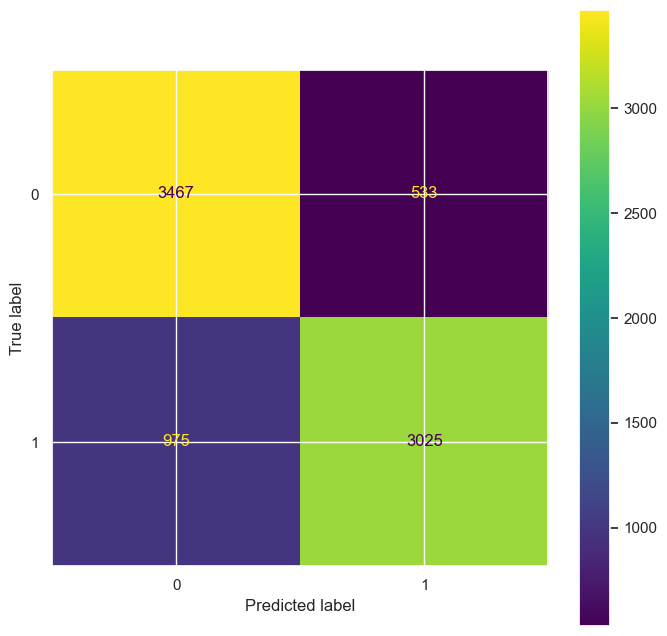

In [23]:
eval(svc_cv, X_train, X_test)

## Testing

In [24]:
test_review = "I'm done with this movie."

# Preprocess and extract features (assuming preprocess_text and extract_features return strings)
test_review_preprocess = preprocess_text(test_review)
test_review_feature = extract_features(test_review_preprocess, positive_words, negative_words)
test_review_df = pd.DataFrame([test_review_feature])

print(f'Predict: ', test_review)
print(f'Probability with SVC_CV Model (Negative, Positive):', svc_cv.predict_proba(test_review_df))


Predict:  I'm done with this movie.
Probability with SVC_CV Model (Negative, Positive): [[0.77606184 0.22393816]]
